In [1]:
# Enable automatic import reloading

%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import triadicsim

# Graph generators

In [2]:
graph_type='Gnp'
num_nodes = 100

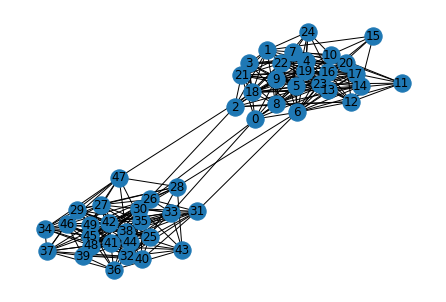

In [203]:
G = triadicsim.graph(50, graph_type=graph_type)
nx.draw(G, with_labels=True)

# Triadic closures

In [188]:
def get_num_mutuals(G):
    num_nodes = len(G)
    num_mutuals = []
    # adj_matrix = nx.linalg.graphmatrix.adjacency_matrix(G).todense()
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            # mutual_i_j = np.dot(adj_matrix[i], adj_matrix[j].T).tolist()[0][0]
            if j in list(G[i]): continue
            if i in list(G[j]): continue
            mutual_i_j = len(set(list(G[i])).intersection(set(list(G[j]))))
            if mutual_i_j:
                num_mutuals.append(((i, j), mutual_i_j))
    # put them in order of most number of mutual connections
    num_mutuals = sorted(num_mutuals, key=lambda x: x[1], reverse=True)
    return num_mutuals

# Get Thresholds

In [138]:
def get_seedset(num_nodes, num_seeds):
    return np.random.choice(np.arange(num_nodes), num_seeds)

Text(0, 0.5, '# nodes')

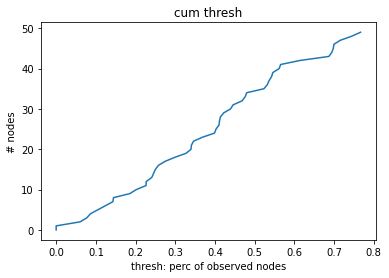

In [139]:
# Assign thresholds to everyone

def get_thresholds(num_nodes, mean=0.4, var=0.25):
    thresholds = np.random.normal(mean, var, num_nodes)
    # Scale to between 0 and 1
    thresholds = np.clip(thresholds, 0, 1.1)
    return thresholds

thresholds = get_thresholds(num_nodes)


thresholds_sorted = sorted(thresholds)
cum_thresh = [(thresholds_sorted[i], i) for i in range(len(thresholds_sorted))]
plt.plot([x[0] for x in cum_thresh], [x[1] for x in cum_thresh])
plt.title('cum thresh')
plt.xlabel('thresh: perc of observed nodes')
plt.ylabel('# nodes')

In [201]:
def cascade_population(G, thresholds, 
                       seed_set=None, num_seeds=10,
                       max_rounds=1000):
    # Initalize active nodes
    if seed_set is None:
        seed_set = get_seedset(len(G), num_seeds)
    active_nodes = np.zeros((num_nodes))
    active_nodes[seed_set] = 1

    # Iterate over rounds
    prev_total_active = np.sum(active_nodes)
    for r in range(max_rounds):
        total_active = np.count_nonzero(active_nodes)
        active_visible = total_active / num_nodes
        active_nodes[np.where(thresholds <= active_visible)[0]] += 1 

        total_active = np.count_nonzero(active_nodes)
        if prev_total_active == total_active:
            break
        prev_total_active = total_active
    return total_active, r, active_nodes

total_active, r, active_ndoes = cascade_population(G, thresholds)
total_active, r

(50, 5)

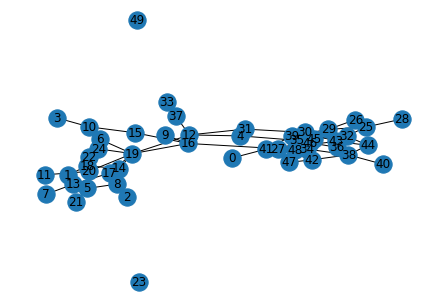

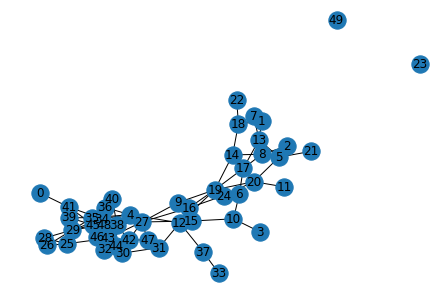

In [145]:
def cascade_graph(G, thresholds, 
                  seed_set=None, num_seeds=10,
                  num_add_edges=0,
                  closure_method=closure_method, 
                  max_rounds=20):
    # Initalize active nodes
    if seed_set is None:
        seed_set = get_seedset(len(G.nodes), num_seeds)
    active_nodes = np.zeros((num_nodes))
    active_nodes[seed_set] = 1
    new_active_nodes = np.zeros((num_nodes))
    num_reached_nodes = []

    def get_num_active_neighbors(G, n):
        """Number of active neighbors"""
        neighbors = list(G[n])
        if len(neighbors) == 0: return 0
        num_active_neighbors = np.count_nonzero([active_nodes[neighbor] for neighbor in neighbors])
        return num_active_neighbors


    prev_total_active = np.sum(active_nodes)
    # Iterate over rounds
    for r in range(max_rounds):
        for n in G.nodes():
            num_active_neighbors = get_num_active_neighbors(G, n)
            
            if len(G[n]) == 0:
                continue
            
            active_visible = num_active_neighbors / len(G[n])
            
            if thresholds[n] <= active_visible:
                new_active_nodes[n] += 1
        active_nodes = new_active_nodes
        total_active = np.count_nonzero(active_nodes)
        num_reached_nodes.append(total_active)

        if total_active == num_nodes:
            break
        prev_total_active = total_active
        
        G, added_connections = closure_round(G, num_add_edges, method=closure_method)
    return total_active, r, active_nodes, np.asarray(num_reached_nodes)

G = triadicsim.graph(num_nodes, graph_type=graph_type)
nx.draw(G, with_labels=True)
plt.show()
total_active, r, active_nodes, num_reached_nodes = cascade_graph(G, thresholds, num_add_edges=1, 
                                                                 closure_method=closure_method)
nx.draw(G, with_labels=True)
plt.show()


# Run some experiments

In [205]:
num_experiments = 20
graph_type='stochastic'
num_nodes = 100
closure_method = 'weighted_random'
max_rounds = 100

def get_title(num_nodes, graph_type, closure_method):
    return f"\n{num_nodes} nodes on {graph_type} with {closure_method} closure"

In [206]:
def get_round_completed(num_reached_nodes):
    round_completed = np.where(num_reached_nodes == num_nodes)[0]
    if len(round_completed) == 0:
        return -1
    else:
        return round_completed[0]
    
def get_round_max(num_reached_nodes):
    round_completed = np.where(num_reached_nodes == np.max(num_reached_nodes))[0]
    if len(round_completed) == 0:
        return -1
    else:
        return round_completed[0]

[20, 11, -1, -1, -1, 5, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1]


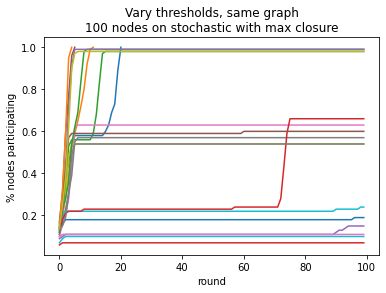

In [207]:
# Vary thresholds, same graph
closure_method = "max"
rounds_completed = []
for i in range(num_experiments):
    G = triadicsim.graph(num_nodes, graph_type=graph_type, seed=0)
    thresholds = get_thresholds(num_nodes)
    
    total_active, r, active_nodes, num_reached_nodes = cascade_graph(G, thresholds, num_add_edges=1, 
                                                                     closure_method=closure_method, 
                                                                     max_rounds=max_rounds)
    plt.plot(num_reached_nodes / num_nodes)
    rounds_completed.append(get_round_completed(num_reached_nodes))
plt.plot()
plt.xlabel('round')
plt.ylabel('% nodes participating')
plt.title('Vary thresholds, same graph' + get_title(num_nodes, graph_type, closure_method))
print(rounds_completed)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


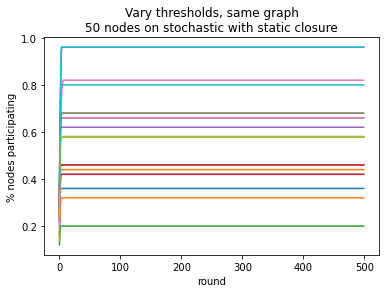

In [186]:
# Vary thresholds, same graph
closure_method = "static"
rounds_completed = []
for i in range(num_experiments):
    G = triadicsim.graph(num_nodes, graph_type=graph_type, seed=0)
    thresholds = get_thresholds(num_nodes)
    
    total_active, r, active_nodes, num_reached_nodes = cascade_graph(G, thresholds, num_add_edges=1, 
                                                                     closure_method=closure_method, 
                                                                     max_rounds=max_rounds)
    plt.plot(num_reached_nodes / num_nodes)
    rounds_completed.append(get_round_completed(num_reached_nodes))
plt.plot()
plt.xlabel('round')
plt.ylabel('% nodes participating')
plt.title('Vary thresholds, same graph' + get_title(num_nodes, graph_type, closure_method))
print(rounds_completed)

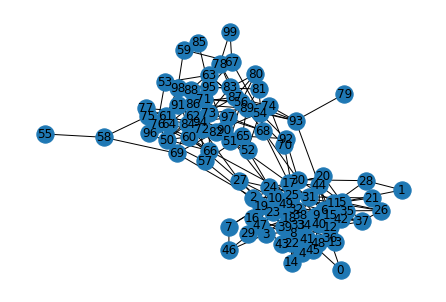

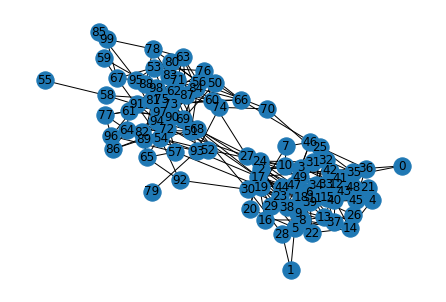

In [82]:
G = triadicsim.graph(num_nodes, graph_type=graph_type)
nx.draw(G, with_labels=True)
plt.show()
total_active, r, active_nodes, num_reached_nodes = cascade_graph(G, thresholds, num_add_edges=1, 
                                                                 closure_round=closure_round)
nx.draw(G, with_labels=True)
plt.show()